In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os
import sys

sns.set_style("whitegrid")
sns.set_palette("husl")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [3]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "kath":
            label = "{}, {}, {}, {}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, Min: {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.1})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [4]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))

        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)
        
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
        if ylog:
            plt.yscale("log")
        format_plot(xlabel, ylabel)
        write_file(plot_prefix, show=True)




In [ ]:
# Basic

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181208_net"
do_plot = False
do_evaluate = True
networks = [["densenet"], ["mobilenetv2", "mobilenet"], ["resnet"]]
for network in networks:
    plot_dir = "{}/181208_net/{}".format(plot_home_dir, network[0])
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    if do_plot:
        plot_experiments([baseline_exp, "181224_random", "181115_seedednew_aug"],
                              experiment_dir,
                              plot_dir,
                              nets=network)

    if do_evaluate:
        if "densenet" in network:
            baseline_file = "deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2"
        else:
            baseline_file = "deterministic_cifar10_{}_1_128_0.0_0.0005_trial1_seed1337_v2".format(network[0])
        if "resnet" in network:
            baseline_exp = "181115_seedednew_aug"
        print "-------------{} ---------------".format(network)
        Evaluate.evaluate(experiment_dir,
                          baseline_exp,
                          baseline_file,
                          baseline_exp,
                          max_error=20)

In [ ]:
#rsync -avzh  ahjiang@ops.narwhal.pdl.cmu.edu:/proj/BigLearning/ahjiang/output/cifar100/18* data/output/cifar100/ && rsync -avzh  ahjiang@ops.orca.pdl.cmu.edu:/datasets/BigLearning/ahjiang/output/cifar100/181211_test data/output/cifar100

plot_home_dir = "../plots/cifar100/"
experiment_dir = "../data/output/cifar100"
#exps = ["181211_test", "181216_cifar100"]
exps = ["181211_test", "181224_cifar100", "190106_cifar100"]
do_plot = True
do_evaluate = True

plot_dir = "{}/181224_cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if do_plot:
    plot_experiments(exps,
                     experiment_dir,
                     plot_dir)
if do_evaluate:
    Evaluate.evaluate(experiment_dir,
                      "181211_test",
                      "deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                      "181224_cifar100",
                      max_error=70)
    Evaluate.evaluate(experiment_dir,
                      "181211_test",
                      "deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                      "190106_cifar100",
                      max_error=70)
        Evaluate.evaluate(experiment_dir,
                      "181211_test",
                      "deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                      "190106_cifar100",
                      max_error=70)
    

In [ ]:
# MNIST

plot_home_dir = "../plots/mnist/"
experiment_dir = "../data/output/mnist"
baseline_exp = "181230"
baseline_file = "deterministic_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2"
do_plot = False
do_evaluate = True

plot_dir = "{}/181230/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = [baseline_exp]

if do_plot:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1])

baseline_path = os.path.join(experiment_dir, baseline_exp, baseline_file)
if do_evaluate:
    Evaluate.evaluate(experiment_dir,
             baseline_exp,
             baseline_file,
             baseline_exp,
             max_error=10)

In [ ]:
# Adam optimizer

plot_home_dir = "../plots/"
experiment_dir = "../data/output/cifar10"
exps = ["190105_adam_lite"]
do_plot = False
do_evaluate = True

plot_dir = "{}/190105_adam_lite/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
mobilenet_plot_dir = "{}/mobilenet/".format(plot_dir)
if not os.path.exists(mobilenet_plot_dir):
    os.makedirs(mobilenet_plot_dir)
    
densenet_plot_dir = "{}/densenet/".format(plot_dir)
if not os.path.exists(densenet_plot_dir):
    os.makedirs(densenet_plot_dir)
    
if do_plot:
    plot_experiments(exps,
                     experiment_dir,
                     densenet_plot_dir, lrs=[0.1], nets=["densenet"])
    plot_experiments(exps,
                     experiment_dir,
                     densenet_plot_dir, lrs=[0.01], nets=["densenet"])
    plot_experiments(exps,
                     experiment_dir,
                     mobilenet_plot_dir, lrs=[0.1], nets=["mobilenet"])
    plot_experiments(exps,
                     experiment_dir,
                     mobilenet_plot_dir, lrs=[0.01], nets=["mobilenet"])
if do_evaluate:
    print("---------- Densenet 0.01 ---------------")
    Evaluate.evaluate(experiment_dir,
             "190105_adam",
             "deterministic_cifar10_densenet_1_64_0.01_0_trial1_seed1337_v2",
             "190105_adam")
    print("---------- Densenet 0.1 ---------------")
    Evaluate.evaluate(experiment_dir,
             "190105_adam",
             "deterministic_cifar10_densenet_1_64_0.1_0_trial1_seed1337_v2",
             "190105_adam")
    print("---------- Mobilenet 0.01 ---------------")
    Evaluate.evaluate(experiment_dir,
             "190105_adam",
             "deterministic_cifar10_mobilenet_1_128_0.01_0_trial1_seed1337_v2",
             "190105_adam")
    print("---------- Mobilenet 0.1 ---------------")
    Evaluate.evaluate(experiment_dir,
             "190105_adam",
             "deterministic_cifar10_mobilenet_1_128_0.1_0_trial1_seed1337_v2",
             "190105_adam")

In [ ]:
# Label error
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"

plot_dir = "{}/190116_shuffle/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
mobilenet_plot_dir = "{}/mobilenet/".format(plot_dir)
if not os.path.exists(mobilenet_plot_dir):
    os.makedirs(mobilenet_plot_dir)
    
experiment_names = ["190116_shuffle0.001", "190116_shuffle0.01", "190116_shuffle0.1"]

if True:
    plot_experiments([experiment_names[0]],
                     experiment_dir,
                     mobilenet_plot_dir,
                     nets=["mobilenet"])
    plot_experiments([experiment_names[1]],
                     experiment_dir,
                     mobilenet_plot_dir,
                     nets=["mobilenet"])
    plot_experiments([experiment_names[2]],
                     experiment_dir,
                     mobilenet_plot_dir,
                     nets=["mobilenet"])



In [ ]:
# Distributions
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"

plot_dir = "{}/190116_dists/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
mobilenet_plot_dir = "{}/mobilenet/".format(plot_dir)
if not os.path.exists(mobilenet_plot_dir):
    os.makedirs(mobilenet_plot_dir)
    
experiment_names = ["190116_dists"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     mobilenet_plot_dir,
                     nets=["mobilenet"])

In [ ]:
# SVHN
plot_home_dir = "../plots"
experiment_dir = "../data/output/svhn/"

plot_dir = "{}/190118_giulio/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190118_giulio"]

if False:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir)
if True:
    Evaluate.evaluate(experiment_dir,
             "190118_giulio",
             "sampling_svhn_resnet18_1.0_128_0.01_0.0005_trial1_seed1337_v2",
             "190118_giulio")
    
    

In [ ]:
# Kath18
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190120_kath/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190120_kath","190120_kathuniform", "190120_kathprimed", "190120_kathbiased", "181208_net"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2", "mobilenet"])

    

In [ ]:
#rsync -avzh  ahjiang@ops.narwhal.pdl.cmu.edu:/proj/BigLearning/ahjiang/output/cifar100/18* data/output/cifar100/ && rsync -avzh  ahjiang@ops.orca.pdl.cmu.edu:/datasets/BigLearning/ahjiang/output/cifar100/181211_test data/output/cifar100

plot_home_dir = "../plots/cifar100/"
experiment_dir = "../data/output/cifar100"
exps = ["icml18_lite"]
do_plot = False
do_evaluate = True

plot_dir = "{}/icml18_lite/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if do_plot:
    plot_experiments(exps,
                     experiment_dir,
                     plot_dir)
if do_evaluate:
    Evaluate.evaluate(experiment_dir,
                      "icml18_lite",
                      "deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
                      "icml18_lite",
                      max_error=70)

    

In [ ]:
# basic trials

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181208_net"
exp = "190104_trials"

do_plot = False
do_evaluate = True
networks = [["densenet"], ["mobilenetv2", "mobilenet"], ["resnet"]]
for network in networks:
    plot_dir = "{}/190104_trials/{}".format(plot_home_dir, network[0])
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    if do_plot:
        plot_experiments([baseline_exp, exp, "181115_seedednew_aug"],
                              experiment_dir,
                              plot_dir,
                              nets=network)

    if do_evaluate:
        if "densenet" in network:
            baseline_file = "deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2"
        else:
            baseline_file = "deterministic_cifar10_{}_1_128_0.0_0.0005_trial1_seed1337_v2".format(network[0])
        if "resnet" in network:
            baseline_exp = "181115_seedednew_aug"
        print "-------------{} ---------------".format(network)
        Evaluate.evaluate(experiment_dir,
                          baseline_exp,
                          baseline_file,
                          exp,
                          max_error=20)

In [ ]:
# POSTMIAMI
# sampling, basic

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181208_net"
do_plot = True
do_evaluate = False
#networks = [["densenet"], ["mobilenetv2", "mobilenet"], ["resnet"]]
networks = [["mobilenetv2"], ["mobilenet"], ["renset"], ["densenet"]]
for network in networks:
    plot_dir = "{}/190205_sample/{}".format(plot_home_dir, network[0])
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    if do_plot:
        plot_experiments([baseline_exp, "190205_sample"],
                          experiment_dir,
                          plot_dir,
                          nets=network,
                          trials=[1])

    if do_evaluate:
        if "densenet" in network:
            baseline_file = "deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2"
        else:
            baseline_file = "deterministic_cifar10_{}_1_128_0.0_0.0005_trial1_seed1337_v2".format(network[0])
        if "resnet" in network:
            baseline_exp = "181115_seedednew_aug"
        print "-------------{} ---------------".format(network)
        Evaluate.evaluate(experiment_dir,
                          baseline_exp,
                          baseline_file,
                          baseline_exp,
                          max_error=20)

In [ ]:
# hinge

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181208_net"
do_plot = True
networks = [["densenet"], ["mobilenetv2", "mobilenet"], ["resnet"]]
for network in networks:
    plot_dir = "{}/190208_hinge/{}".format(plot_home_dir, network[0])
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    if do_plot:
        plot_experiments([baseline_exp, "181115_seedednew_aug", "190208_hinge"],
                          experiment_dir,
                          plot_dir,
                          nets=network,
                          trials=[1])


In [ ]:
# Kath18 Mobilenetv2

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190311_kath/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190311_kath", "190205_sample"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"])

In [ ]:
# scalars

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190316_scale/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190316_scale2", "190316_scale4", "190316_scale6", "190316_scale8", "190205_sample"]

if False:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])
if True:
    target_errors = [8, 9, 10, 20, 30]
    for experiment_name in experiment_names:
        print("----------------")
        print(experiment_name)
        print("----------------")
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2")
        Evaluate.evaluate_file(filepath, target_errors)
    
    experiment_name = "190205_sample"
    print("----------------")
    print(experiment_name, "1.0")
    print("----------------")
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2")
    Evaluate.evaluate_file(filepath, target_errors)
    

In [ ]:
# squared

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190316_squared/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
#experiment_names = ["190317_squared", "190317_custom", "190205_sample"]
experiment_names = ["190317_squared", "190317_custom"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])

In [ ]:
# imagenet

plot_home_dir = "../plots"
experiment_dir = "../data/output/imagenet/"

plot_dir = "{}/190317_imagenet/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190317_imagenet"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1])

sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338

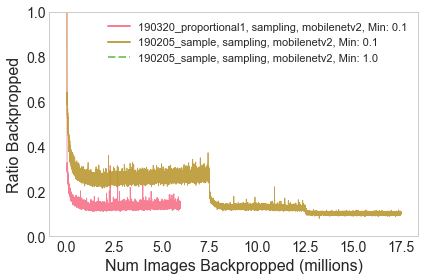

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


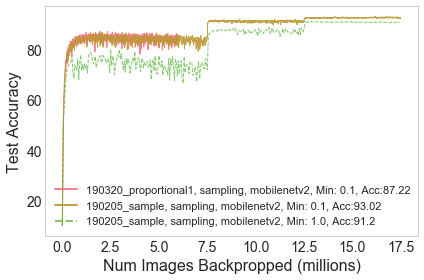

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


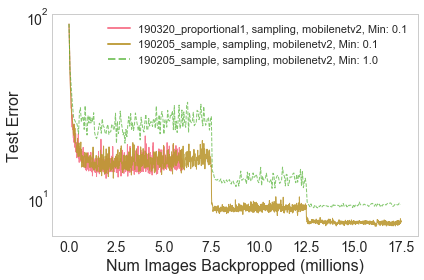

../plots/190320_proportional//190205_sample_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


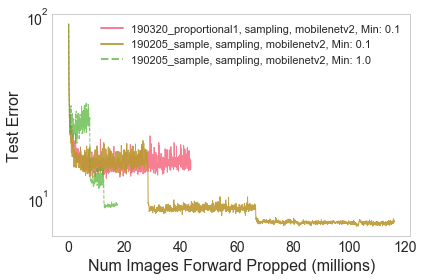

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


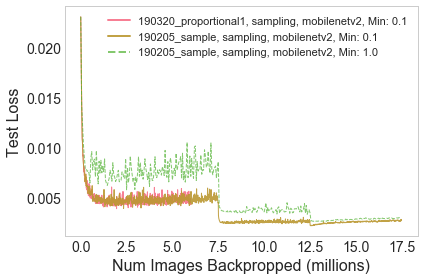

sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338

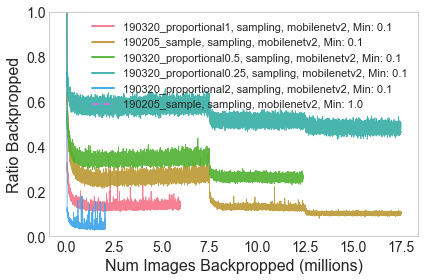

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


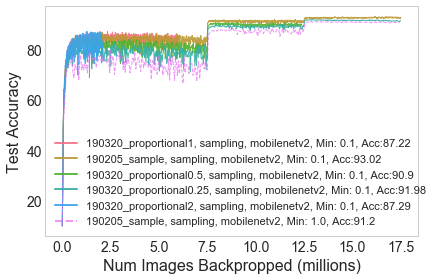

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


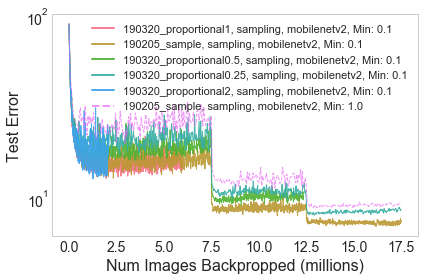

../plots/190320_proportional//190205_sample_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


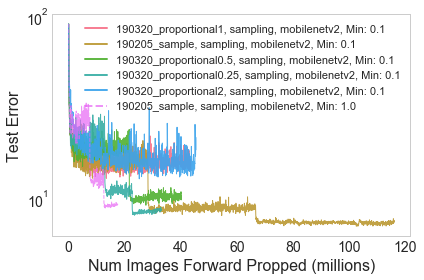

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


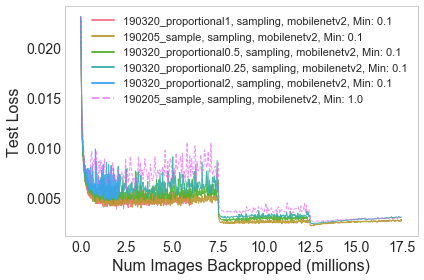

<Figure size 432x288 with 0 Axes>

In [9]:
# proportional

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190320_proportional/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190205_sample", "190320_proportional1"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])
    
experiment_names = ["190205_sample", "190320_proportional1", "190320_proportional2", "190320_proportional0.5", "190320_proportional0.25"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])
if False:
    target_errors = [15, 20, 30, 40]
    for experiment_name in experiment_names:
        print("----------------")
        print(experiment_name)
        print("----------------")
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2")
        Evaluate.evaluate_file(filepath, target_errors)
    
    experiment_name = "190320_proportional"
    print("----------------")
    print(experiment_name, "1.0")
    print("----------------")
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2")
    Evaluate.evaluate_file(filepath, target_errors)
    